In [80]:
!git clone https://github.com/AdityaK210901/Track1.git


fatal: destination path 'Track1' already exists and is not an empty directory.


In [81]:
!ls Track1

driving_log.csv  IMG


In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random
import os


In [83]:
datadir= 'Track1'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

<ipython-input-83-fa29f335ee9f>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


center  \
0  C:\Simulator_Data\IMG\center_2023_07_15_13_35_03_170.jpg   
1  C:\Simulator_Data\IMG\center_2023_07_15_13_35_03_285.jpg   
2  C:\Simulator_Data\IMG\center_2023_07_15_13_35_03_386.jpg   
3  C:\Simulator_Data\IMG\center_2023_07_15_13_35_03_489.jpg   
4  C:\Simulator_Data\IMG\center_2023_07_15_13_35_03_591.jpg   

                                                      left  \
0   C:\Simulator_Data\IMG\left_2023_07_15_13_35_03_170.jpg   
1   C:\Simulator_Data\IMG\left_2023_07_15_13_35_03_285.jpg   
2   C:\Simulator_Data\IMG\left_2023_07_15_13_35_03_386.jpg   
3   C:\Simulator_Data\IMG\left_2023_07_15_13_35_03_489.jpg   
4   C:\Simulator_Data\IMG\left_2023_07_15_13_35_03_591.jpg   

                                                      right  steering  \
0   C:\Simulator_Data\IMG\right_2023_07_15_13_35_03_170.jpg  0.0        
1   C:\Simulator_Data\IMG\right_2023_07_15_13_35_03_285.jpg  0.0        
2   C:\Simulator_Data\IMG\right_2023_07_15_13_35_03_386.jpg  0.0        
3   C:\Simulator_Data\IMG\right_2023_07_15_13_35_03_489.jpg  0.0        
4   C:\Simulator_Data\IMG\right_2023_07_15_13_35_03_591.jpg  0.0        

   throttle  reverse     speed  
0  0.0       0.0      0.000078  
1  0.0       0.0      0.000079  
2  0.0       0.0      0.000082  
3  0.0       0.0      0.000078  
4  0.0       0.0      0.000080

In [84]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2023_07_15_13_35_03_170.jpg  left_2023_07_15_13_35_03_170.jpg   
1  center_2023_07_15_13_35_03_285.jpg  left_2023_07_15_13_35_03_285.jpg   
2  center_2023_07_15_13_35_03_386.jpg  left_2023_07_15_13_35_03_386.jpg   
3  center_2023_07_15_13_35_03_489.jpg  left_2023_07_15_13_35_03_489.jpg   
4  center_2023_07_15_13_35_03_591.jpg  left_2023_07_15_13_35_03_591.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2023_07_15_13_35_03_170.jpg  0.0       0.0       0.0      0.000078  
1  right_2023_07_15_13_35_03_285.jpg  0.0       0.0       0.0      0.000079  
2  right_2023_07_15_13_35_03_386.jpg  0.0       0.0       0.0      0.000082  
3  right_2023_07_15_13_35_03_489.jpg  0.0       0.0       0.0      0.000078  
4  right_2023_07_15_13_35_03_591.jpg  0.0       0.0       0.0      0.000080

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


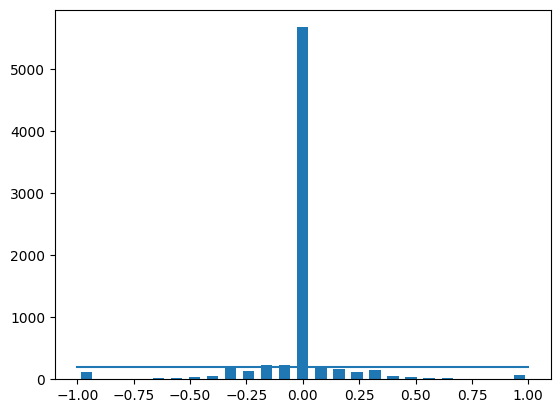

In [85]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
print(bins)

In [86]:
# Now balancing the data#

total data: 7566
removed: 5524
remaining: 2042


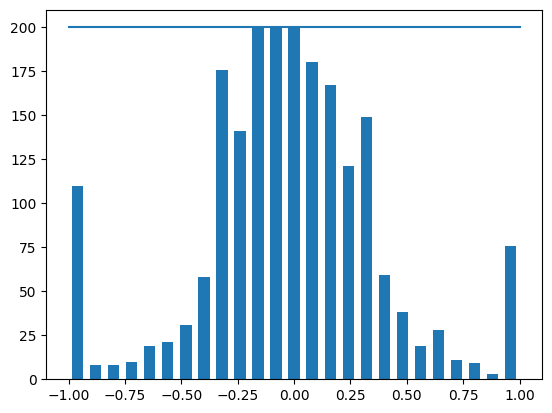

In [87]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))



In [88]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]

    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))

  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2023_07_15_13_35_06_568.jpg
left        left_2023_07_15_13_35_06_568.jpg  
right       right_2023_07_15_13_35_06_568.jpg 
steering    0.0                               
throttle    0.0                               
reverse     0.0                               
speed       0.000079                          
Name: 32, dtype: object


In [89]:
X_train, X_valid,y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state =6)
print('Training Samples: {}\nValid Samples; {}'.format(len(X_train), len(X_valid)))

Training Samples: 1633
Valid Samples; 409


Text(0.5, 1.0, 'Validatin set')

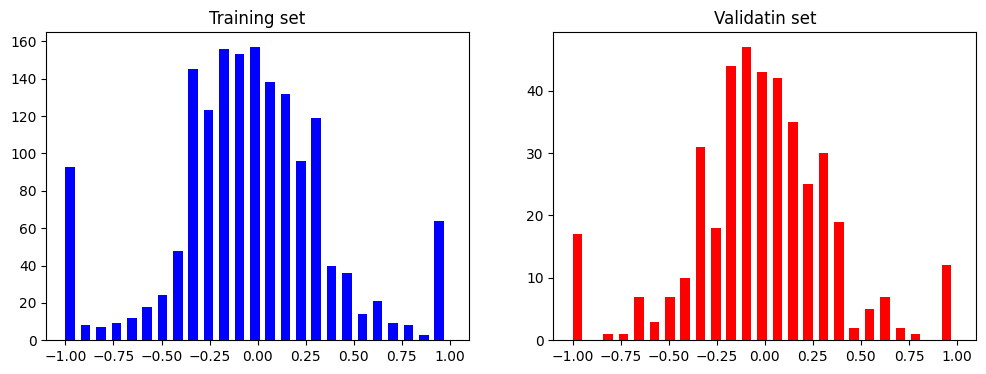

In [90]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validatin set')

In [91]:
#preprocessing

def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135, :,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

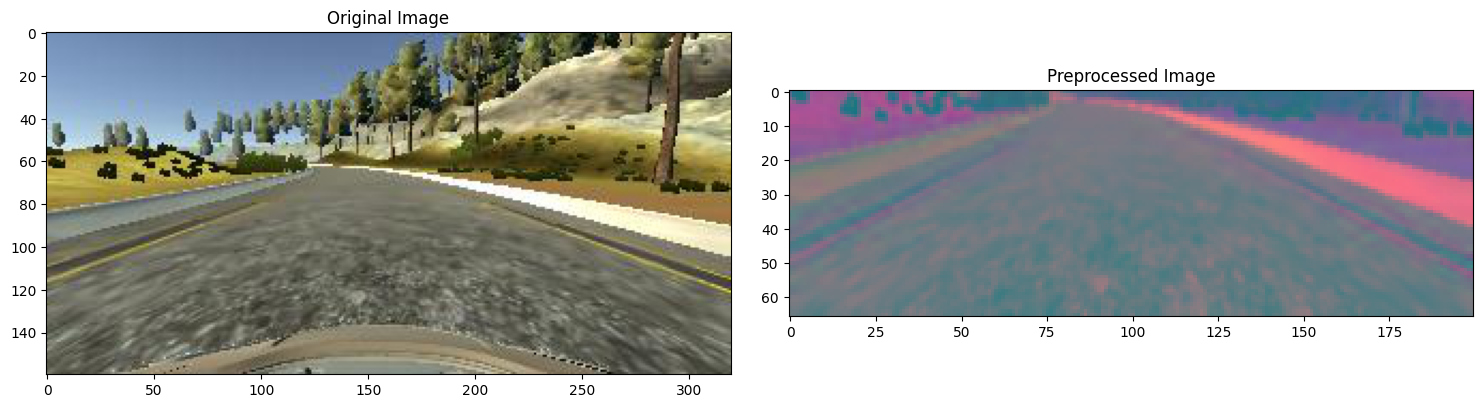

In [92]:
image  = image_paths[500]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')



In [93]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(1633, 66, 200, 3)


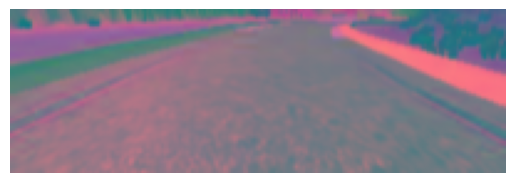

In [94]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [95]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
  model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation ='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))

  optimizer= Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)

  return model

In [96]:
model = nvidia_model()
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_37 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_38 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_39 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_14 (Dropout)        (None, 1, 18, 64)         0         
                                                                 
 flatten_7 (Flatten)         (None, 1152)             

In [97]:
history = model.fit(X_train, y_train, epochs = 30, validation_data = (X_valid, y_valid), batch_size=100, verbose=1, shuffle=1 )

Epoch 1/30
17/17 [==============================] - 2s 60ms/step - loss: 0.4978 - val_loss: 0.1434
Epoch 2/30
17/17 [==============================] - 1s 30ms/step - loss: 0.1883 - val_loss: 0.1383
Epoch 3/30
17/17 [==============================] - 1s 30ms/step - loss: 0.1796 - val_loss: 0.1391
Epoch 4/30
17/17 [==============================] - 0s 30ms/step - loss: 0.1770 - val_loss: 0.1376
Epoch 5/30
17/17 [==============================] - 0s 26ms/step - loss: 0.1696 - val_loss: 0.1401
Epoch 6/30
17/17 [==============================] - 0s 24ms/step - loss: 0.1668 - val_loss: 0.1288
Epoch 7/30
17/17 [==============================] - 0s 24ms/step - loss: 0.1602 - val_loss: 0.1241
Epoch 8/30
17/17 [==============================] - 0s 26ms/step - loss: 0.1535 - val_loss: 0.1137
Epoch 9/30
17/17 [==============================] - 0s 27ms/step - loss: 0.1530 - val_loss: 0.1095
Epoch 10/30
17/17 [==============================] - 0s 24ms/step - loss: 0.1392 - val_loss: 0.0983
Epoch 11/

Text(0.5, 0, 'epoch')

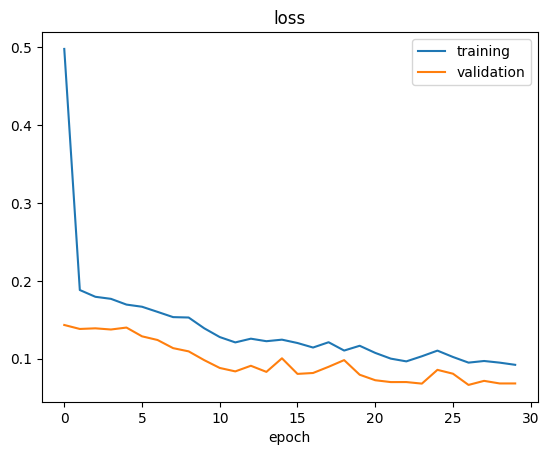

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

In [100]:
model.save('model.h5')

In [101]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>